In [1]:
import os

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, LogisticRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score
import joblib
import pandas as pd
import numpy as np

In [2]:
"""
线性回归直接预测房子价格
:return: None
"""
# 获取数据
fe_cal = fetch_california_housing(data_home='../data')

print("获取特征值")
print(fe_cal.data.shape)
print('-' * 50)
print(fe_cal.data[0])
print("目标值")
print(fe_cal.target) #单位是10万美金
print(fe_cal.DESCR)
print('-' * 50)
print(fe_cal.feature_names) #特征列的名字

获取特征值
(20640, 8)
--------------------------------------------------
[   8.3252       41.            6.98412698    1.02380952  322.
    2.55555556   37.88       -122.23      ]
目标值
[4.526 3.585 3.521 ... 0.923 0.847 0.894]
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/

MedInc - 中位收入（Median Income）
HouseAge - 房屋年龄（House Age）
AveRooms - 平均房间数（Average Number of Rooms）
AveBedrms - 平均卧室数（Average Number of Bedrooms）
Population - 人口数量（Population）
AveOccup - 平均居住人数（Average Occupancy）
Latitude - 纬度（Latitude）
Longitude - 经度（Longitude）

In [3]:
fe_cal.target.shape

(20640,)

In [4]:
# 分割数据集到训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(fe_cal.data, fe_cal.target, test_size=0.25, random_state=1)
#
print(x_train.shape)
#
# # 进行标准化处理(?) 目标值处理？
# # 特征值和目标值是都必须进行标准化处理, 实例化两个标准化API
std_x = StandardScaler()
#
x_train = std_x.fit_transform(x_train) #训练集标准化
x_test = std_x.transform(x_test) #测试集标准化

# 目标值进行了标准化，暂时没有对目标值进行标准化处理
# std_y = StandardScaler()
#
# temp = y_train.reshape(-1, 1) #-1代表把剩余的元素都堆到哪一维
#
# #标签进行标准化
# # 目标值是一维的，这里需要传进去2维的
# y_train = std_y.fit_transform(y_train.reshape(-1, 1))
# print(y_train.shape)
# y_test = std_y.transform(y_test.reshape(-1, 1))
# print(y_test.shape)

(15480, 8)


In [16]:
test1=np.array([1,2,3])
print(test1.shape)
test1.reshape(-1,1).shape

(3,)


(3, 1)

In [6]:
import os
# # estimator预测
# # # 正规方程求解方式预测结果，正规方程进行线性回归
lr = LinearRegression()
# fit是耗时的
lr.fit(x_train, y_train)
#回归系数可以看特征与目标之间的相关性
print('回归系数', lr.coef_)
#
y_predict = lr.predict(x_test)
# 预测测试集的房子价格，通过inverse得到真正的房子价格
# y_lr_predict = std_y.inverse_transform(y_predict)
# 保存训练好的模型，模型中保存的是w的值，也保存了模型结构
#保存模型放在fit之后即可
os.unlink('./tmp/test.pkl') # 删除之前的模型文件
joblib.dump(lr, "./tmp/test.pkl")
print("正规方程测试集里面每个房子的预测价格：", y_predict[0:10])
#下面是求测试集的损失，用均方误差，公式是(y_test-y_predict)^2/n
print("正规方程的均方误差：", mean_squared_error(y_test, y_predict))

回归系数 [ 0.83167028  0.12159502 -0.26758589  0.30983997 -0.00518054 -0.04040421
 -0.90736902 -0.88212727]
正规方程测试集里面每个房子的预测价格： [2.12391852 0.93825754 2.7088455  1.70873764 2.82954754 3.50376456
 3.0147162  1.62781292 1.74317518 2.01897806]
正规方程的均方误差： 0.5356532845422556


# 2 加载保存的模型

In [7]:
#模拟上线时加载模型
model = joblib.load("./tmp/test.pkl")
# # 因为目标值进行了标准化，一定要把预测后的值逆向转换回来
y_predict = model.predict(x_test)

#
print("保存的模型预测的结果：", y_predict)
print("正规方程的均方误差：", mean_squared_error(y_test, y_predict))

# print("正规方程inverse后的均方误差：", mean_squared_error(std_y.inverse_transform(y_test),
#                                                std_y.inverse_transform(y_predict)))

保存的模型预测的结果： [2.12391852 0.93825754 2.7088455  ... 1.24263061 2.73771901 1.75800594]
正规方程的均方误差： 0.5356532845422556


In [19]:
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_squared_error(y_true, y_pred)

0.375

In [20]:
#人工求均方误差
(np.square(3 - 2.5) + np.square(0.5) + 1) / 4


0.375

# 3 线性回归之梯度下降去进行房价预测

In [22]:
# 梯度下降去进行房价预测,数据量大要用这个
# learning_rate的不同方式，代表学习率变化的算法不一样,比如constant,invscaling,adaptive
# 默认可以去调 eta0 = 0.008，会改变learning_rate的初始值
# learning_rate='optimal',alpha是正则化力度，但是会影响学习率的值，由alpha来算学习率
# penalty代表正则化，分为l1和l2
# eta0=0.01, penalty='l2',max_iter=1000
sgd = SGDRegressor(eta0=0.01,penalty='l2', max_iter=1000)
# # 训练
sgd.fit(x_train, y_train)
#
print('梯度下降的回归系数', sgd.coef_)
#
# 预测测试集的房子价格
# y_sgd_predict = std_y.inverse_transform(sgd.predict(x_test).reshape(-1, 1))
y_predict = sgd.predict(x_test)
# print("梯度下降测试集里面每个房子的预测价格：", y_sgd_predict)
print("梯度下降的均方误差：", mean_squared_error(y_test, y_predict))
# print("梯度下降的原始房价量纲均方误差：", mean_squared_error(std_y.inverse_transform(y_test), y_sgd_predict))

梯度下降的回归系数 [ 0.81355506  0.10499394 -0.23356786  0.31334747 -0.01303565 -0.01679472
 -0.9117157  -0.86697705]
梯度下降的均方误差： 0.5355432396304047


In [11]:
w=1
alpha=0.7
def loss(w):
    return 2*w**2+3*w+2
def dao_shu(w):
    return 4*w+3
for i in range(30):
    w=w-alpha*dao_shu(w)
    print(f'w {w} 损失{loss(w)}')

w -3.8999999999999995 损失20.71999999999999
w 4.919999999999999 损失65.17279999999998
w -10.955999999999996 损失209.19987199999983
w 17.620799999999992 损失675.8475852799994
w -33.817439999999976 损失2187.786176307197
w 58.77139199999995 损失7086.4672112353155
w -107.8885055999999 损失22958.193764402422
w 192.09931007999978 损失74382.58779666382
w -347.87875814399956 损失240997.6244611907
w 624.0817646591992 损失780830.3432542577
w -1125.4471763865586 损失2529888.352143795
w 2023.7049174958051 损失8196836.300945894
w -3644.768851492449 损失26557747.65506469
w 6558.483932686408 损失86047100.4424096
w -11807.371078835533 损失278792603.4734071
w 21251.167941903957 损失903288033.2938386
w -38254.202295427116 损失2926653225.912036
w 68855.4641317688 损失9482356449.994993
w -123941.93543718383 损失30722834896.023777
w 223093.38378693088 损失99541985061.15703
w -401570.1908164755 损失322516031596.1886
w 722824.2434696557 损失1044951942369.6908
w -1301085.73824538 损失3385644293275.837
w 2341952.228841684 损失10969487510211.748
w -4215516.1

# 4 岭回归

In [23]:
# # # 岭回归去进行房价预测
#岭回归是对线性回归加入L2正则化，L2正则化是对系数的平方和进行惩罚
#alpha就是补偿的系数
#正规方程求解，加补偿就可以让正规方程可逆
rd = Ridge(alpha=0.02)

rd.fit(x_train, y_train)

print(rd.coef_)
#
# # 预测测试集的房子价格
print(rd.predict(x_test).shape)
# y_rd_predict = std_y.inverse_transform(rd.predict(x_test))
y_predict = rd.predict(x_test)
# print("岭回归里面每个房子的预测价格：", y_rd_predict)

print("岭回归的均方误差：", mean_squared_error(y_test, y_predict))
# print("岭回归的均方误差：", mean_squared_error(std_y.inverse_transform(y_test), y_rd_predict))

[ 0.83166963  0.12159681 -0.26758236  0.30983534 -0.00517992 -0.04040432
 -0.90735215 -0.88211025]
(5160,)
岭回归的均方误差： 0.5356531179270396


In [24]:
# # # Lasso回归去进行房价预测
#alpha就是补偿的系数
print(x_train.shape)
print(y_train.shape)
ls = Lasso(alpha=0.001)

ls.fit(x_train, y_train)

print(ls.coef_)
#
# # 预测测试集的房子价格
print(ls.predict(x_test).shape)
print('-'*50)
# y_ls_predict = std_y.inverse_transform(ls.predict(x_test).reshape(-1,1))
y_predict = ls.predict(x_test)
# print("Lasso回归里面每个房子的预测价格：", y_rd_predict)
#
print("Lasso回归的均方误差：", mean_squared_error(y_test, y_predict))
# print("Lasso回归的均方误差：", mean_squared_error(std_y.inverse_transform(y_test), y_ls_predict))

(15480, 8)
(15480,)
[ 0.82655827  0.1225482  -0.25369194  0.29596304 -0.00381001 -0.03948424
 -0.89646842 -0.87060253]
(5160,)
--------------------------------------------------
Lasso回归的均方误差： 0.5356324125105497


# 5 逻辑回归

In [2]:
np.log(0.5)

-0.6931471805599453

In [3]:
np.log(0.3)

-1.2039728043259361

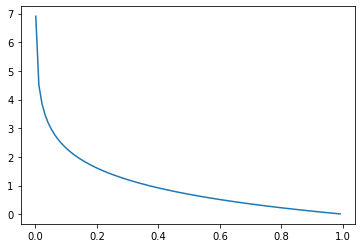

In [4]:
x=np.arange(0.001,1,0.01) #0-1之间，步长0.01
import matplotlib.pyplot as plt
plt.plot(x,-np.log(x))  #以e为底部
plt.show()

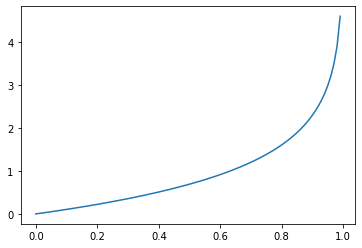

In [5]:
x=np.arange(0,1,0.01)
import matplotlib.pyplot as plt
plt.plot(x,-np.log(1-x))
plt.show()

In [2]:
"""
逻辑回归做二分类进行癌症预测（根据细胞的属性特征）
:return: NOne
"""
# 构造列标签名字
column = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
          'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli',
          'Mitoses', 'Class']

# 读取数据
# data = pd.read_csv(
#     "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data",
#     names=column)
data = pd.read_csv(
    "./data/breast-cancer-wisconsin.csv",
    names=column)
# print(data) #想看可以解除
#当你读取数据时，看上去是数值的列，读进来是字符串，说明里边
# 存在了非数值情况
print(data.info())
print(data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           699 non-null    int64 
 1   Clump Thickness              699 non-null    int64 
 2   Uniformity of Cell Size      699 non-null    int64 
 3   Uniformity of Cell Shape     699 non-null    int64 
 4   Marginal Adhesion            699 non-null    int64 
 5   Single Epithelial Cell Size  699 non-null    int64 
 6   Bare Nuclei                  699 non-null    object
 7   Bland Chromatin              699 non-null    int64 
 8   Normal Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB
None
        Sample code number  Clump Thickness  Uniformity of Cell Size  \
count         6.990000e+0

In [3]:
data['Bare Nuclei'].unique() #因为上面发现它是object类型

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [4]:
# 缺失值进行处理
data = data.replace(to_replace='?', value=np.nan)
#直接删除，哪一行有空值，就删除对应的样本
data = data.dropna()
print('-' * 50)
print(data.shape)

--------------------------------------------------
(683, 11)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           683 non-null    int64 
 1   Clump Thickness              683 non-null    int64 
 2   Uniformity of Cell Size      683 non-null    int64 
 3   Uniformity of Cell Shape     683 non-null    int64 
 4   Marginal Adhesion            683 non-null    int64 
 5   Single Epithelial Cell Size  683 non-null    int64 
 6   Bare Nuclei                  683 non-null    object
 7   Bland Chromatin              683 non-null    int64 
 8   Normal Nucleoli              683 non-null    int64 
 9   Mitoses                      683 non-null    int64 
 10  Class                        683 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 64.0+ KB


In [10]:
column[10]

'Class'

In [6]:
#分类的类别是2和4,对应 "良性", "恶性"
data[column[10]].unique()

array([2, 4], dtype=int64)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           683 non-null    int64 
 1   Clump Thickness              683 non-null    int64 
 2   Uniformity of Cell Size      683 non-null    int64 
 3   Uniformity of Cell Shape     683 non-null    int64 
 4   Marginal Adhesion            683 non-null    int64 
 5   Single Epithelial Cell Size  683 non-null    int64 
 6   Bare Nuclei                  683 non-null    object
 7   Bland Chromatin              683 non-null    int64 
 8   Normal Nucleoli              683 non-null    int64 
 9   Mitoses                      683 non-null    int64 
 10  Class                        683 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 64.0+ KB


In [7]:
column[6]

'Bare Nuclei'

In [8]:
#把第6列的字符串转化为数字类型
data[column[6]] = data[column[6]].astype('int16')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int16
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int16(1), int64(10)
memory usage: 60.0 KB


In [10]:
# 进行数据的分割,第零列是编号，不可以作为特征，把第1-9列作为特征，第10列作为标签
x_train, x_test, y_train, y_test = train_test_split(data[column[1:10]], data[column[10]], test_size=0.25,
                                                    random_state=1)

# 进行标准化处理
std = StandardScaler()

x_train = std.fit_transform(x_train) #训练集标准化
x_test = std.transform(x_test) #测试集标准化
x_train[0]

array([-1.21629973, -0.70863282, -0.75174943,  0.04301674, -0.55657068,
       -0.71054972, -0.99312055, -0.62911518, -0.36280962])

In [11]:
#
# # 逻辑回归预测
# C正则化力度
# solver = 'liblinear'  solver是学习率优化算法，就是学习率会随着epoch的变化而变化
#epoch就代表第几次迭代
#max_iter 最大迭代次数
lg = LogisticRegression(C=0.5, solver='lbfgs')
#
lg.fit(x_train, y_train)
# 逻辑回归的权重参数，了解，没那么重要
print(lg.coef_)

y_predict = lg.predict(x_test)
print(y_predict) #预测的标签
print("准确率：", lg.score(x_test, y_test))
print(y_test[0:5])
print('-'*50)
print(lg.predict_proba(x_test)[0:5])  #得出对应分类的概率


[[1.11400191 0.25293086 0.78938469 0.60986034 0.0728013  1.10834397
  0.7794668  0.64312128 0.67692658]]
[2 2 2 4 2 4 2 2 4 4 2 2 4 2 2 4 2 2 2 2 2 2 2 4 4 2 2 2 4 4 2 2 4 4 2 4 2
 2 4 4 4 2 2 4 2 2 2 2 4 2 2 2 4 2 2 2 4 2 2 2 2 4 2 2 2 4 2 4 4 2 2 4 2 2
 4 2 2 2 2 2 2 2 4 2 4 4 2 2 2 4 2 2 4 2 2 4 4 2 2 4 2 2 4 4 2 2 2 2 4 2 4
 4 2 4 2 4 2 2 2 2 4 2 4 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 4 4 2 2 4 2 2 2 2 4
 2 2 2 2 2 4 2 4 2 4 2 2 4 2 4 2 4 4 2 4 2 2 2]
准确率： 0.9824561403508771
444    2
24     2
195    2
49     4
375    2
Name: Class, dtype: int64
--------------------------------------------------
[[0.94893919 0.05106081]
 [0.99494175 0.00505825]
 [0.98365149 0.01634851]
 [0.02707911 0.97292089]
 [0.99732446 0.00267554]]


In [12]:
# 为什么还要看下召回率，labels和target_names对应
# macro avg 平均值  weighted avg 加权平均值
print(classification_report(y_test, y_predict, labels=[2, 4], target_names=["良性", "恶性"]))
#AUC计算要求是二分类，不需要是0和1
print("AUC指标：", roc_auc_score(y_test, y_predict))

              precision    recall  f1-score   support

          良性       0.97      1.00      0.99       111
          恶性       1.00      0.95      0.97        60

    accuracy                           0.98       171
   macro avg       0.99      0.97      0.98       171
weighted avg       0.98      0.98      0.98       171

AUC指标： 0.975


In [21]:
print(x_train.shape)
print(x_test.shape)

(512, 9)
(171, 9)


In [29]:
print(-np.log(0.1))

2.3025850929940455


In [31]:
-np.log(0.9)



0.10536051565782628

In [13]:
x=-3/10
y=5*x**2+3*x+4
y

3.55

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 优先使用黑体或微软雅黑
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题
# 目标函数
def f(x):
    return (x - 2) ** 2

# 梯度（导数）
def grad_f(x):
    return 2 * (x - 2)

# 超参数
learning_rate = 0.15
num_iterations = 30
x_start = -3.0  # 初始点

# 记录轨迹
x_vals = [x_start]
f_vals = [f(x_start)]

# 梯度下降迭代
x = x_start
for i in range(num_iterations):
    g = grad_f(x)
    x = x - learning_rate * g
    x_vals.append(x)
    f_vals.append(f(x))

# 转为 NumPy 数组便于绘图
x_vals = np.array(x_vals)
f_vals = np.array(f_vals)

# 创建图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- 左图：函数曲线 + 优化路径 ---
x_plot = np.linspace(-4, 6, 200)
y_plot = f(x_plot)
ax1.plot(x_plot, y_plot, 'b-',)

# ---

### 🔍 运行效果说明

# - **左图**：抛物线是目标函数，红点是每次迭代的   $  (x, f(x))  $   位置，箭头显示从起点走向最小值。
# - **右图**：损失值随着迭代快速下降，趋于 0。
# - 即使从很远的点（如   $  x=-3  $  ）出发，也能稳定收敛到   $  x=2  $  。
#
# > ✅ 你可以尝试修改 `learning_rate`：
# > - 设为 `0.8`：会震荡但可能仍收敛；
# > - 设为 `1.1`：会发散（数值越来越大）！

# ---

### 🧩 如果你想要**二维版本**（比如   $  f(x, y) = x^2 + y^2  $  ），我也可以提供带等高线图或 3D 动画的版本！

# 是否需要？🙂)
ax1.plot(x_vals, f_vals, 'ro-', label='梯度下降路径', markersize=5)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.set_title('目标函数与优化路径')
ax1.legend()
ax1.grid(True)

# 标出起点和终点
ax1.annotate('起点', xy=(x_vals[0], f_vals[0]), xytext=(-3, 25),
             arrowprops=dict(arrowstyle='->', color='red'))
ax1.annotate('终点', xy=(x_vals[-1], f_vals[-1]), xytext=(3, 5),
             arrowprops=dict(arrowstyle='->', color='green'))

# --- 右图：损失随迭代变化 ---
ax2.plot(range(len(f_vals)), f_vals, 'go-', markersize=5)
ax2.set_xlabel('迭代次数')
ax2.set_ylabel('损失 f(x)')
ax2.set_title('损失下降曲线')
ax2.grid(True)

plt.tight_layout()
plt.show()

# 打印最终结果
print(f"经过 {num_iterations} 次迭代：")
print(f"  最终 x = {x_vals[-1]:.4f}")
print(f"  最小值 f(x) = {f_vals[-1]:.6f}")
print(f"  真实最小值在 x=2, f(2)=0")

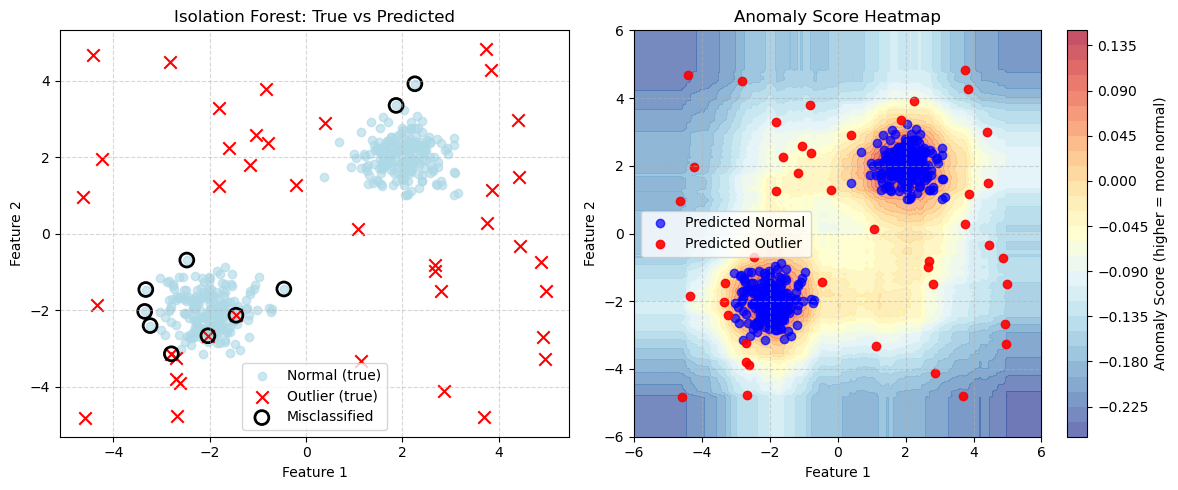

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# ----------------------------
# 1. 生成模拟数据
# ----------------------------
np.random.seed(42)

# 正常数据：两个高斯簇
X_normal_1 = np.random.randn(200, 2) * 0.5 + [2, 2]
X_normal_2 = np.random.randn(200, 2) * 0.5 + [-2, -2]
X_normal = np.vstack([X_normal_1, X_normal_2])

# 异常点：均匀分布在边缘
X_outliers = np.random.uniform(low=-5, high=5, size=(40, 2))
X = np.vstack([X_normal, X_outliers])
y_true = np.hstack([np.ones(len(X_normal)), -np.ones(len(X_outliers))])  # 1=正常, -1=异常

# ----------------------------
# 2. 训练孤立森林
# ----------------------------
clf = IsolationForest(
    contamination=0.1,      # 预估异常比例
    random_state=42,
    n_estimators=100
)
y_pred = clf.fit_predict(X)          # 预测：1=正常, -1=异常
anomaly_scores = clf.decision_function(X)  # 异常分数（越大越正常，越小越异常）

# ----------------------------
# 3. 创建网格用于热力图
# ----------------------------
xx, yy = np.meshgrid(
    np.linspace(-6, 6, 200),
    np.linspace(-6, 6, 200)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_scores = clf.decision_function(grid_points).reshape(xx.shape)

# ----------------------------
# 4. 可视化
# ----------------------------
plt.figure(figsize=(12, 5))

# --- 左图：真实标签 vs 预测结果 ---
plt.subplot(1, 2, 1)
# 正常点（真实）
plt.scatter(X_normal[:, 0], X_normal[:, 1], c='lightblue', label='Normal (true)', alpha=0.6)
# 异常点（真实）
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', marker='x', s=80, label='Outlier (true)')

# 预测错误的点（用黑色圈出）
misclassified = y_pred != y_true
if misclassified.any():
    plt.scatter(X[misclassified, 0], X[misclassified, 1],
                facecolors='none', edgecolors='black', s=100, linewidth=2, label='Misclassified')

plt.title('Isolation Forest: True vs Predicted')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, linestyle='--', alpha=0.5)

# --- 右图：异常分数热力图 ---
plt.subplot(1, 2, 2)
# 热力图：越红表示越异常（注意 decision_function 越小越异常）
contour = plt.contourf(xx, yy, grid_scores, levels=30, cmap='RdYlBu_r', alpha=0.7)
plt.colorbar(contour, label='Anomaly Score (higher = more normal)')

# 叠加原始数据点
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], c='blue', label='Predicted Normal', alpha=0.7)
plt.scatter(X[y_pred == -1, 0], X[y_pred == -1, 1], c='red', label='Predicted Outlier', alpha=0.9)

plt.title('Anomaly Score Heatmap')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()